# ArtifactGen Class Comparison Notebook

Comprehensive per-class comparison of DDPM vs WGAN-GP generative models for EEG artifact window synthesis.\n
This notebook evaluates model performance across all artifact classes (e.g., chewing, muscle, eye movement, etc.).\n
For each class:\n
- Load real samples from that class\n
- Generate synthetic samples for that class\n
- Compute metrics (MMD, PSD, diversity, etc.)\n
- Aggregate results for comparison\n

> NOTE: This focuses on per-class metrics to assess how well models generalize across different artifact types.

In [1]:
# Imports & environment setup
import os
import sys
import json
import math
import random
import textwrap
import importlib
import pathlib
import itertools
from pathlib import Path
import numpy as np
import pandas as pd
import yaml
import scipy.signal as sps
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
try:
    import umap
    HAVE_UMAP = True
except Exception:
    HAVE_UMAP = False
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('whitegrid')

# Always save figures to ArtifactGen/paper/figs
FIG_DIR = Path('C:/works/ArtifactGen/paper/figs')
FIG_DIR.mkdir(parents=True, exist_ok=True)
print('Figures ->', FIG_DIR.resolve())

# Add project root to path so we can import src.* reliably when running from notebook folder
ROOT = Path(__file__).parent.parent if '__file__' in globals() else Path('..')
if (ROOT / 'src').exists():
    sys.path.append(str(ROOT))

from src.eval.generate import generate_samples  # uses models under src.models
from src.models import UNet1D, WGANGPGenerator  # (ensures availability)

RESULTS_DIR = ROOT / 'results'
GEN_DIR = RESULTS_DIR / 'generated'
CKPT_DIR = RESULTS_DIR / 'checkpoints'

Figures -> C:\works\ArtifactGen\paper\figs


In [2]:
# Force rescale real_samples and R to [-1, 1] per channel for all analysis and plots
def scale_to_unit(x):
    # x: (N, C, L) or (C, L)
    if isinstance(x, np.ndarray) and x.size > 0:
        if x.ndim == 3:
            min_c = x.min(axis=(0,2), keepdims=True)
            max_c = x.max(axis=(0,2), keepdims=True)
            denom = (max_c - min_c) + 1e-9
            x = 2 * (x - min_c) / denom - 1
        elif x.ndim == 2:
            min_c = x.min(axis=1, keepdims=True)
            max_c = x.max(axis=1, keepdims=True)
            denom = (max_c - min_c) + 1e-9
            x = 2 * (x - min_c) / denom - 1
    return x
if 'real_samples' in locals():
    real_samples = scale_to_unit(real_samples)
if 'R' in locals():
    R = scale_to_unit(R)

## Load Configs
We extract key hyperparameters for each model to contextualize metric differences.

In [3]:
ddpm_cfg_path = Path('../configs/ddpm_raw.yaml') if (Path.cwd().name == 'notebooks') else Path('configs/ddpm_raw.yaml')
wgan_cfg_path = Path('../configs/wgan_raw.yaml') if (Path.cwd().name == 'notebooks') else Path('configs/wgan_raw.yaml')
with open(ddpm_cfg_path, 'r', encoding='utf-8') as f: ddpm_cfg = yaml.safe_load(f)
with open(wgan_cfg_path, 'r', encoding='utf-8') as f: wgan_cfg = yaml.safe_load(f)
def cfg_summary(name, cfg):
    m = cfg['model']; tr = cfg['training']; data = cfg['data']
    return {
        'model': name,
        'channels': m.get('channels'),
        'length': m.get('length'),
        'num_classes': m.get('num_classes'),
        'epochs': tr.get('epochs'),
        'batch_size': tr.get('batch_size'),
        'lr': tr.get('lr'),
        'window_seconds': data.get('window_seconds'),
        'sample_rate': data.get('sample_rate'),
    }
cfg_table = pd.DataFrame([cfg_summary('DDPM', ddpm_cfg), cfg_summary('WGAN-GP', wgan_cfg)])
cfg_table

,model,channels,length,num_classes,epochs,batch_size,lr,window_seconds,sample_rate
0,DDPM,8,500,5,200,32,1e-4,2.0,250
1,WGAN-GP,8,250,5,200,64,2e-4,1.0,250


## Per-Class Evaluation
Loop over all classes, load/generate samples, and compute metrics.

In [4]:
DO_GENERATE_DDPM = True
DO_GENERATE_WGAN = True
N_GEN = 256  # smaller for per-class
REAL_LIMIT = 500  # per class

def find_checkpoint(dir_: Path, pattern='*.pth'):
    cks = sorted(dir_.glob(pattern), key=lambda p: p.stat().st_mtime)
    return cks[-1] if cks else None

ddpm_ckpt = CKPT_DIR / 'ddpm_unet_best.pth'
if not ddpm_ckpt.exists():
    ddpm_ckpt = find_checkpoint(CKPT_DIR)
wgan_ckpt = CKPT_DIR / 'wgan_generator_best.pth'
if not wgan_ckpt.exists():
    wgan_ckpt = find_checkpoint(CKPT_DIR, pattern='*wgan_generator*.pth')

print('DDPM ckpt:', ddpm_ckpt)
print('WGAN ckpt:', wgan_ckpt)

# Load class map
VAL_ROOT = Path('../data/processed/train') if (Path.cwd().name == 'notebooks') else Path('data/processed/train')
class_map_df = pd.read_csv(VAL_ROOT.parent / 'class_map.csv')
class_map = list(zip(class_map_df['short'], class_map_df['display']))
class_to_idx = {short: i for i, (short, display) in enumerate(class_map)}
classes = class_map_df['short'].tolist()

# Metric utilities (same as model_comparison)
def channel_stats(x):
    return x.mean(axis=(0,2)), x.std(axis=(0,2))

def welch_psd(x, fs, nperseg=128):
    if x.size==0: return np.array([]), np.array([])
    C = x.shape[1]
    psds = []
    for c in range(C):
        f, p = sps.welch(x[:,c,:], fs=fs, nperseg=min(nperseg, x.shape[-1]))
        p = p.mean(axis=0)
        psds.append(p)
    return f, np.array(psds)

def bandpower(f, psd, bands):
    out = {}
    for name, (lo, hi) in bands.items():
        m = (f>=lo) & (f<hi)
        if m.sum()>0:
            out[name] = psd[:,m].sum(axis=1)
        else:
            out[name] = np.zeros(psd.shape[0])
    return out

def rbf_mmd(X, Y, sigmas=(10,20,40,80)):
    if X.size==0 or Y.size==0: return np.nan
    XX = cdist(X, X, 'euclidean')**2
    YY = cdist(Y, Y, 'euclidean')**2
    XY = cdist(X, Y, 'euclidean')**2
    mmd = 0.0
    for s in sigmas:
        kXX = np.exp(-XX/(2*s*s))
        kYY = np.exp(-YY/(2*s*s))
        kXY = np.exp(-XY/(2*s*s))
        m = kXX.mean() + kYY.mean() - 2*kXY.mean()
        mmd += m
    return mmd / len(sigmas)

def diversity(x):
    if x.shape[0] < 3: return np.nan
    idx = np.random.choice(x.shape[0], size=min(64, x.shape[0]), replace=False)
    flat = x[idx].reshape(len(idx), -1)
    corr = np.corrcoef(flat)
    upper = corr[np.triu_indices_from(corr, k=1)]
    return 1 - upper.mean()

def effect_size(a, b):
    if a.size==0 or b.size==0: return np.nan
    return (a.mean()-b.mean())/math.sqrt(0.5*(a.var()+b.var())+1e-9)

FS = ddpm_cfg['data']['sample_rate'] if 'data' in ddpm_cfg else 250
BANDS = {'delta':(0.5,4),'theta':(4,8),'alpha':(8,13),'beta':(13,30),'gamma':(30,45)}

# Store results
results = {}

device = 'cuda' if (importlib.util.find_spec('torch') and __import__('torch').cuda.is_available()) else 'cpu'
print('Device:', device)

for cls in classes:
    print(f'\n--- Processing class: {cls} ---')
    class_id = class_to_idx[cls]
    display_name = class_map_df[class_map_df['short'] == cls]['display'].iloc[0]
    class_root = VAL_ROOT / display_name
    
    # Load real samples for this class
    real_samples = []
    real_labels = []
    extensions = {'.npy', '.npz', '.pt'}
    if class_root.exists():
        for f in class_root.glob('**/*'):
            if f.suffix.lower() in extensions:
                try:
                    if f.suffix.lower() == '.pt':
                        arr = __import__('torch').load(f).numpy()
                    elif f.suffix.lower() == '.npz':
                        npz = np.load(f)
                        arr = npz[npz.files[0]]
                    else:
                        arr = np.load(f)
                    if arr.ndim == 2:
                        if arr.shape[0] <= 32:
                            pass
                        elif arr.shape[1] <= 32:
                            arr = arr.T
                        else:
                            continue
                        if arr.shape == (8, 250):
                            real_samples.append(arr)
                            real_labels.append(class_id)
                except Exception:
                    pass
            if len(real_samples) >= REAL_LIMIT:
                break
    if len(real_samples) == 0:
        print(f'No real samples for {cls}')
        continue
    real_samples = np.stack(real_samples)
    real_labels = np.array(real_labels)
    # Scale real_samples to [-1, 1] per channel immediately after loading
    def scale_to_unit(x):
        if isinstance(x, np.ndarray) and x.size > 0:
            if x.ndim == 3:
                min_c = x.min(axis=(0,2), keepdims=True)
                max_c = x.max(axis=(0,2), keepdims=True)
                denom = (max_c - min_c) + 1e-9
                x = 2 * (x - min_c) / denom - 1
            elif x.ndim == 2:
                min_c = x.min(axis=1, keepdims=True)
                max_c = x.max(axis=1, keepdims=True)
                denom = (max_c - min_c) + 1e-9
                x = 2 * (x - min_c) / denom - 1
        return x
    real_samples = scale_to_unit(real_samples)
    print(f'Real samples shape: {real_samples.shape}')
    
    # Generate samples for this class
    ddpm_X = np.empty((0,))
    wgan_X = np.empty((0,))
    
    if DO_GENERATE_DDPM and ddpm_ckpt is not None:
        print('Generating DDPM...')
        ddpm_X, _ = generate_samples(ddpm_cfg, str(ddpm_ckpt), __import__('torch').device(device), 'ddpm', n=N_GEN, class_id=class_id)
    if DO_GENERATE_WGAN and wgan_ckpt is not None:
        print('Generating WGAN...')
        wgan_X, _ = generate_samples(wgan_cfg, str(wgan_ckpt), __import__('torch').device(device), 'wgan_gp', n=N_GEN, class_id=class_id)
    
    # Compute metrics
    R = real_samples[:512] if real_samples.shape[0] > 512 else real_samples
    D = ddpm_X[:512] if ddpm_X.size > 0 else np.empty((0,8,250))
    G = wgan_X[:512] if wgan_X.size > 0 else np.empty((0,8,250))
    
    R_flat = R.reshape(R.shape[0], -1) if R.size else np.empty((0,))
    D_flat = D.reshape(D.shape[0], -1) if D.size else np.empty((0,))
    G_flat = G.reshape(G.shape[0], -1) if G.size else np.empty((0,))
    
    # Only compute MMD if arrays are 2D and feature dimensions match
    mmd_r_d = np.nan
    mmd_r_g = np.nan
    mmd_d_g = np.nan
    if R_flat.size and D_flat.size and R_flat.ndim == 2 and D_flat.ndim == 2 and R_flat.shape[1] == D_flat.shape[1]:
        mmd_r_d = rbf_mmd(R_flat, D_flat)
    if R_flat.size and G_flat.size and R_flat.ndim == 2 and G_flat.ndim == 2 and R_flat.shape[1] == G_flat.shape[1]:
        mmd_r_g = rbf_mmd(R_flat, G_flat)
    if D_flat.size and G_flat.size and D_flat.ndim == 2 and G_flat.ndim == 2 and D_flat.shape[1] == G_flat.shape[1]:
        mmd_d_g = rbf_mmd(D_flat, G_flat)
    
    fR, psdR = welch_psd(R, FS)
    fD, psdD = welch_psd(D, FS)
    fG, psdG = welch_psd(G, FS)
    psdD_a = np.interp(fR, fD, psdD.mean(axis=0)) if fD.size and fR.size else np.array([])
    psdG_a = np.interp(fR, fG, psdG.mean(axis=0)) if fG.size and fR.size else np.array([])
    psd_err_ddpm = np.linalg.norm(psdR.mean(axis=0) - psdD_a) / (np.linalg.norm(psdR.mean(axis=0)) + 1e-9) if psdR.size and psdD_a.size else np.nan
    psd_err_wgan = np.linalg.norm(psdR.mean(axis=0) - psdG_a) / (np.linalg.norm(psdR.mean(axis=0)) + 1e-9) if psdR.size and psdG_a.size else np.nan
    
    div_ddpm = diversity(D) if D.size else np.nan
    div_wgan = diversity(G) if G.size else np.nan
    div_real = diversity(R) if R.size else np.nan
    
    results[cls] = {
        'MMD(R,DDPM)': mmd_r_d,
        'MMD(R,WGAN)': mmd_r_g,
        'MMD(DDPM,WGAN)': mmd_d_g,
        'PSD L2 Error DDPM': psd_err_ddpm,
        'PSD L2 Error WGAN': psd_err_wgan,
        'Diversity DDPM': div_ddpm,
        'Diversity WGAN': div_wgan,
        'Diversity Real': div_real,
    }

# Display results
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

DDPM ckpt: ..\results\checkpoints\ddpm_unet_best.pth
WGAN ckpt: ..\results\checkpoints\wgan_generator_best.pth
Device: cuda

--- Processing class: musc ---
No real samples for musc

--- Processing class: eyem ---
No real samples for eyem

--- Processing class: elec ---
No real samples for elec

--- Processing class: chew ---
No real samples for chew

--- Processing class: shiv ---
Real samples shape: (1, 8, 250)
Generating DDPM...
Generating WGAN...
Generating WGAN...


,"MMD(R,DDPM)","MMD(R,WGAN)","MMD(DDPM,WGAN)",PSD L2 Error DDPM,PSD L2 Error WGAN,Diversity DDPM,Diversity WGAN,Diversity Real
shiv,NaN,0.907306,NaN,1.259132,0.322237,0.99965,0.323085,NaN


In [5]:
# Debug: Print DDPM/WGAN sample shapes and check for empty arrays or mismatches
print(f'Class: {cls}')
print('  Real samples shape:', R.shape)
print('  DDPM samples shape:', D.shape, '| Empty:', D.size == 0)
print('  WGAN samples shape:', G.shape, '| Empty:', G.size == 0)
if D.size and R.size:
    print('  DDPM/Real feature dim match:', D.reshape(D.shape[0], -1).shape[1] == R.reshape(R.shape[0], -1).shape[1])
else:
    print('  DDPM or Real samples missing')
if G.size and R.size:
    print('  WGAN/Real feature dim match:', G.reshape(G.shape[0], -1).shape[1] == R.reshape(R.shape[0], -1).shape[1])
else:
    print('  WGAN or Real samples missing')

Class: shiv
  Real samples shape: (1, 8, 250)
  DDPM samples shape: (256, 8, 500) | Empty: False
  WGAN samples shape: (256, 8, 250) | Empty: False
  DDPM/Real feature dim match: False
  WGAN/Real feature dim match: True


## Assemble Generated Arrays
Load DDPM and WGAN generated arrays (downsample / upsample if lengths mismatch).

In [6]:
# Define generated_files mapping: keys 'ddpm' and 'wgan' to tuple of (samples_path, labels_path)
# Example: search for files in GEN_DIR matching expected patterns
generated_files = {}
for key in ['ddpm', 'wgan']:
    sample_file = None
    label_file = None
    for f in GEN_DIR.glob(f'{key}*samples*.npy'):
        sample_file = f
        break
    for f in GEN_DIR.glob(f'{key}*labels*.npy'):
        label_file = f
        break
    if sample_file and label_file:
        generated_files[key] = (str(sample_file), str(label_file))
# If no files found, generated_files will be empty and load_gen will return empty arrays
def load_gen(key):
    if key not in generated_files: return np.empty((0,)), np.empty((0,))
    s_path, l_path = generated_files[key]
    X = np.load(s_path)
    y = np.load(l_path)
    return X, y
ddpm_X, ddpm_y = load_gen('ddpm')
wgan_X, wgan_y = load_gen('wgan')
print('DDPM gen shape:', ddpm_X.shape)
print('WGAN gen shape:', wgan_X.shape)
# Debug: Check array existence and shape before harmonization
print('real_samples defined:', 'real_samples' in locals())
if 'real_samples' in locals(): print('real_samples shape:', getattr(real_samples, 'shape', 'Not ndarray'))
print('ddpm_X defined:', 'ddpm_X' in locals())
if 'ddpm_X' in locals(): print('ddpm_X shape:', getattr(ddpm_X, 'shape', 'Not ndarray'))
print('wgan_X defined:', 'wgan_X' in locals())
if 'wgan_X' in locals(): print('wgan_X shape:', getattr(wgan_X, 'shape', 'Not ndarray'))
# Harmonize all arrays to the minimum length
def resample_to(x, target_len):
    if not isinstance(x, np.ndarray) or x.size == 0: return x
    if x.shape[-1] == target_len: return x
    return sps.resample(x, target_len, axis=-1)
# Only include arrays that are defined and are numpy ndarrays with size > 0
arrays = []
for name in ['real_samples', 'ddpm_X', 'wgan_X']:
    if name in locals():
        arr = locals()[name]
        if isinstance(arr, np.ndarray) and arr.size > 0:
            arrays.append(arr)
lengths = [arr.shape[-1] for arr in arrays]
if lengths:
    min_len = min(lengths)
    if 'real_samples' in locals() and isinstance(real_samples, np.ndarray) and real_samples.size > 0:
        real_samples = resample_to(real_samples, min_len)
    if 'ddpm_X' in locals() and isinstance(ddpm_X, np.ndarray) and ddpm_X.size > 0:
        ddpm_X = resample_to(ddpm_X, min_len)
    if 'wgan_X' in locals() and isinstance(wgan_X, np.ndarray) and wgan_X.size > 0:
        wgan_X = resample_to(wgan_X, min_len)
    print(f"Resampled all arrays to length {min_len}")

DDPM gen shape: (256, 8, 500)
WGAN gen shape: (128, 8, 250)
real_samples defined: True
real_samples shape: (1, 8, 250)
ddpm_X defined: True
ddpm_X shape: (256, 8, 500)
wgan_X defined: True
wgan_X shape: (128, 8, 250)
Resampled all arrays to length 250


## Metric Utilities
Helper functions computing: channel-wise stats, PSD, bandpowers, RBF-MMD, coverage, diversity, and simple effect sizes.

In [7]:
def channel_stats(x):
    # x: (N,C,L)
    return x.mean(axis=(0,2)), x.std(axis=(0,2))

def welch_psd(x, fs, nperseg=128):
    # x: (N,C,L) -> returns freq, PSD averaged over samples
    if x.size==0: return np.array([]), np.array([])
    C = x.shape[1]
    psds = []
    for c in range(C):
        f, p = sps.welch(x[:,c,:], fs=fs, nperseg=min(nperseg, x.shape[-1]))
        p = p.mean(axis=0)  # average over segments if p is 2D
        psds.append(p)
    return f, np.array(psds)  # shape (C,F)

def bandpower(f, psd, bands):
    out = {}
    for name, (lo, hi) in bands.items():
        m = (f>=lo) & (f<hi)
        if m.sum()>0:
            out[name] = psd[:,m].sum(axis=1)
        else:
            out[name] = np.zeros(psd.shape[0])
    return out

def rbf_mmd(X, Y, sigmas=(10,20,40,80)):
    # X,Y: (N,D) flattened
    if X.size==0 or Y.size==0: return np.nan
    XX = cdist(X, X, 'euclidean')**2
    YY = cdist(Y, Y, 'euclidean')**2
    XY = cdist(X, Y, 'euclidean')**2
    mmd = 0.0
    for s in sigmas:
        kXX = np.exp(-XX/(2*s*s))
        kYY = np.exp(-YY/(2*s*s))
        kXY = np.exp(-XY/(2*s*s))
        m = kXX.mean() + kYY.mean() - 2*kXY.mean()
        mmd += m
    return mmd / len(sigmas)

def coverage(labels):
    if labels.size==0: return {}
    uniq, cnt = np.unique(labels, return_counts=True)
    return {int(u): int(c) for u,c in zip(uniq,cnt)}

def diversity(x):
    # mean pairwise correlation across channels/time for random subset
    if x.shape[0] < 3: return np.nan
    idx = np.random.choice(x.shape[0], size=min(64, x.shape[0]), replace=False)
    flat = x[idx].reshape(len(idx), -1)
    corr = np.corrcoef(flat)
    upper = corr[np.triu_indices_from(corr, k=1)]
    return 1 - upper.mean()  # higher => more diversity (less correlation)

def effect_size(a, b):
    # Cohen's d between two vectors
    if a.size==0 or b.size==0: return np.nan
    return (a.mean()-b.mean())/math.sqrt(0.5*(a.var()+b.var())+1e-9)

FS = ddpm_cfg['data']['sample_rate'] if 'data' in ddpm_cfg else 250
BANDS = {'delta':(0.5,4),'theta':(4,8),'alpha':(8,13),'beta':(13,30),'gamma':(30,45)}

## Compute Metrics
We standardize sample counts, flatten for feature-space MMD, compute PSD & bandpower deltas, plus diversity & coverage.

In [8]:
# All data loading and generation is done above. Now compute metrics.

# Ensure all required arrays are defined
if 'real_labels' not in globals(): real_labels = np.array([])
if 'ddpm_y' not in globals(): ddpm_y = np.array([])
if 'wgan_y' not in globals(): wgan_y = np.array([])

# Subsample to balance counts
def balanced_subset(x, n=512):
    if x.size==0: return x
    if x.shape[0] <= n: return x
    idx = np.random.choice(x.shape[0], n, replace=False)
    return x[idx]
R = balanced_subset(real_samples, 512)
D = balanced_subset(ddpm_X, 512)
G = balanced_subset(wgan_X, 512)

# Harmonize shapes for MMD (feature dimension)
def harmonize_shape(a, b):
    if a.size == 0 or b.size == 0: return a, b
    # Ensure channel and length match
    min_channels = min(a.shape[1], b.shape[1]) if a.ndim > 2 and b.ndim > 2 else 1
    min_length = min(a.shape[2], b.shape[2]) if a.ndim > 2 and b.ndim > 2 else 1
    a_h = a[:, :min_channels, :min_length] if a.ndim > 2 else a
    b_h = b[:, :min_channels, :min_length] if b.ndim > 2 else b
    return a_h, b_h

R_h, D_h = harmonize_shape(R, D)
R_h, G_h = harmonize_shape(R, G)
D_h, G_h2 = harmonize_shape(D, G)  # G_h2 for DDPM vs WGAN

# Channel stats
r_mu, r_sd = channel_stats(R_h) if R_h.size else (np.array([]), np.array([]))
d_mu, d_sd = channel_stats(D_h) if D_h.size else (np.array([]), np.array([]))
g_mu, g_sd = channel_stats(G_h) if G_h.size else (np.array([]), np.array([]))

# Flatten for MMD
R_flat = R_h.reshape(R_h.shape[0], -1) if R_h.size else np.empty((0,))
D_flat = D_h.reshape(D_h.shape[0], -1) if D_h.size else np.empty((0,))
G_flat = G_h.reshape(G_h.shape[0], -1) if G_h.size else np.empty((0,))
G_flat2 = G_h2.reshape(G_h2.shape[0], -1) if G_h2.size else np.empty((0,))

mmd_r_d = rbf_mmd(R_flat, D_flat) if R_flat.size and D_flat.size and R_flat.shape[1] == D_flat.shape[1] else np.nan
mmd_r_g = rbf_mmd(R_flat, G_flat) if R_flat.size and G_flat.size and R_flat.shape[1] == G_flat.shape[1] else np.nan
mmd_d_g = rbf_mmd(D_flat, G_flat2) if D_flat.size and G_flat2.size and D_flat.shape[1] == G_flat2.shape[1] else np.nan

# PSD & bandpower
fR, psdR = welch_psd(R_h, FS) if R_h.size else (np.array([]), np.array([]))
fD, psdD = welch_psd(D_h, FS) if D_h.size else (np.array([]), np.array([]))
fG, psdG = welch_psd(G_h, FS) if G_h.size else (np.array([]), np.array([]))
def align_psd(f_ref, psd_ref, f_other, psd_other):
    if len(f_ref)==0 or len(f_other)==0: return psd_other
    if np.array_equal(f_ref, f_other): return psd_other
    # simple interpolation
    return np.vstack([np.interp(f_ref, f_other, psd_other[i, :]) for i in range(psd_other.shape[0])])
psdD_a = align_psd(fR, psdR, fD, psdD) if len(fR)>0 and len(fD)>0 else psdD
psdG_a = align_psd(fR, psdR, fG, psdG) if len(fR)>0 and len(fG)>0 else psdG
# L2 difference normalized
def psd_l2(a,b):
    if a.size==0 or b.size==0: return np.nan
    # Ensure shapes match before subtraction
    if a.shape != b.shape:
        min_shape = tuple(min(sa, sb) for sa, sb in zip(a.shape, b.shape))
        a = a[tuple(slice(0, ms) for ms in min_shape)]
        b = b[tuple(slice(0, ms) for ms in min_shape)]
    return np.linalg.norm(a-b)/ (np.linalg.norm(a)+1e-9)
psd_err_ddpm = psd_l2(psdR, psdD_a) if psdR.size and psdD_a.size else np.nan
psd_err_wgan = psd_l2(psdR, psdG_a) if psdR.size and psdG_a.size else np.nan

# Ensure frequency and PSD arrays match for bandpower
def safe_bandpower(f, psd, bands):
    # If frequency and PSD shapes mismatch, interpolate PSD to match frequency bins
    if psd.size == 0 or f.size == 0: return {}
    if psd.shape[1] != f.shape[0]:
        # Interpolate PSD to match frequency bins
        psd_interp = np.vstack([np.interp(f, np.linspace(f.min(), f.max(), psd.shape[1]), psd[i, :]) for i in range(psd.shape[0])])
        return bandpower(f, psd_interp, bands)
    else:
        return bandpower(f, psd, bands)
bpR = safe_bandpower(fR, psdR, BANDS) if len(fR)>0 and psdR.size else {}
bpD = safe_bandpower(fR, psdD_a, BANDS) if len(fR)>0 and psdD_a.size else {}
bpG = safe_bandpower(fR, psdG_a, BANDS) if len(fR)>0 and psdG_a.size else {}
band_rows = []
for band in BANDS.keys():
    if band not in bpR: continue
    row = {'band':band}
    r = bpR[band] if band in bpR else np.zeros(1)
    d = bpD.get(band, np.zeros_like(r))
    g = bpG.get(band, np.zeros_like(r))
    row['rel_err_ddpm'] = np.mean(np.abs(d-r)/(r+1e-9)) if r.size and d.size else np.nan
    row['rel_err_wgan'] = np.mean(np.abs(g-r)/(r+1e-9)) if r.size and g.size else np.nan
    band_rows.append(row)
band_table = pd.DataFrame(band_rows)

# Coverage & Diversity
def coverage(labels):
    if labels.size==0: return {}
    uniq, cnt = np.unique(labels, return_counts=True)
    return {int(u): int(c) for u,c in zip(uniq,cnt)}

cov_real = coverage(real_labels) if real_labels.size else {}
cov_ddpm = coverage(ddpm_y) if ddpm_y.size else {}
cov_wgan = coverage(wgan_y) if wgan_y.size else {}
div_real = diversity(R_h) if R_h.size else np.nan
div_ddpm = diversity(D_h) if D_h.size else np.nan
div_wgan = diversity(G_h) if G_h.size else np.nan

metric_rows = [
    {'metric':'MMD(R,DDPM)','ddpm':mmd_r_d,'wgan':np.nan},
    {'metric':'MMD(R,WGAN)','ddpm':np.nan,'wgan':mmd_r_g},
    {'metric':'MMD(DDPM,WGAN)','ddpm':mmd_d_g,'wgan':mmd_d_g},
    {'metric':'PSD L2 Error','ddpm':psd_err_ddpm,'wgan':psd_err_wgan},
    {'metric':'Diversity (1-mean corr)','ddpm':div_ddpm,'wgan':div_wgan, 'real':div_real},
 ]
metrics_table = pd.DataFrame(metric_rows)
metrics_table

,metric,ddpm,wgan,real
0,"MMD(R,DDPM)",0.492043,NaN,NaN
1,"MMD(R,WGAN)",NaN,0.534443,NaN
2,"MMD(DDPM,WGAN)",0.036297,0.036297,NaN
3,PSD L2 Error,0.982229,0.737717,NaN
4,Diversity (1-mean corr),0.999957,0.957172,NaN


### Bandpower Relative Error
Lower is better (closer to real distribution).

In [9]:
band_table

,band,rel_err_ddpm,rel_err_wgan
0,delta,0.842673,0.419414
1,theta,4.419954,2.849189
2,alpha,12.171906,4.923104
3,beta,21.520990,5.634048
4,gamma,36.476166,5.264387


## Channel Mean/Std Comparison
Effect sizes (Cohen's d) for per-channel aggregated amplitude distribution differences.

In [10]:
chan_rows = []
for i in range(len(r_mu)) if r_mu.size else []:
    row = {'channel': i}
    if d_mu.size: row['d_mu_diff'] = d_mu[i]-r_mu[i]; row['d_mean_effect'] = effect_size(d_mu[i:i+1], r_mu[i:i+1])
    if g_mu.size: row['g_mu_diff'] = g_mu[i]-r_mu[i]; row['g_mean_effect'] = effect_size(g_mu[i:i+1], r_mu[i:i+1])
    chan_rows.append(row)
channel_table = pd.DataFrame(chan_rows)
channel_table.head()

,channel,d_mu_diff,d_mean_effect,g_mu_diff,g_mean_effect
0,0,-0.085116,-2691.592205,-0.135765,-4293.268659
1,1,0.027207,860.356000,0.133562,4223.611140
2,2,0.228605,7229.129154,0.338037,10689.670862
3,3,0.153037,4839.460414,0.239055,7559.594413
4,4,0.117913,3728.727985,0.167288,5290.117818


## Visualization: Example Windows
Overlay real vs synthetic windows for a random class + channel.

## Visualization: Example Windows (Channel 1)
Overlay real vs synthetic windows for channel 1.


Saved C:\works\ArtifactGen\paper\figs\examples_windows_multi.png


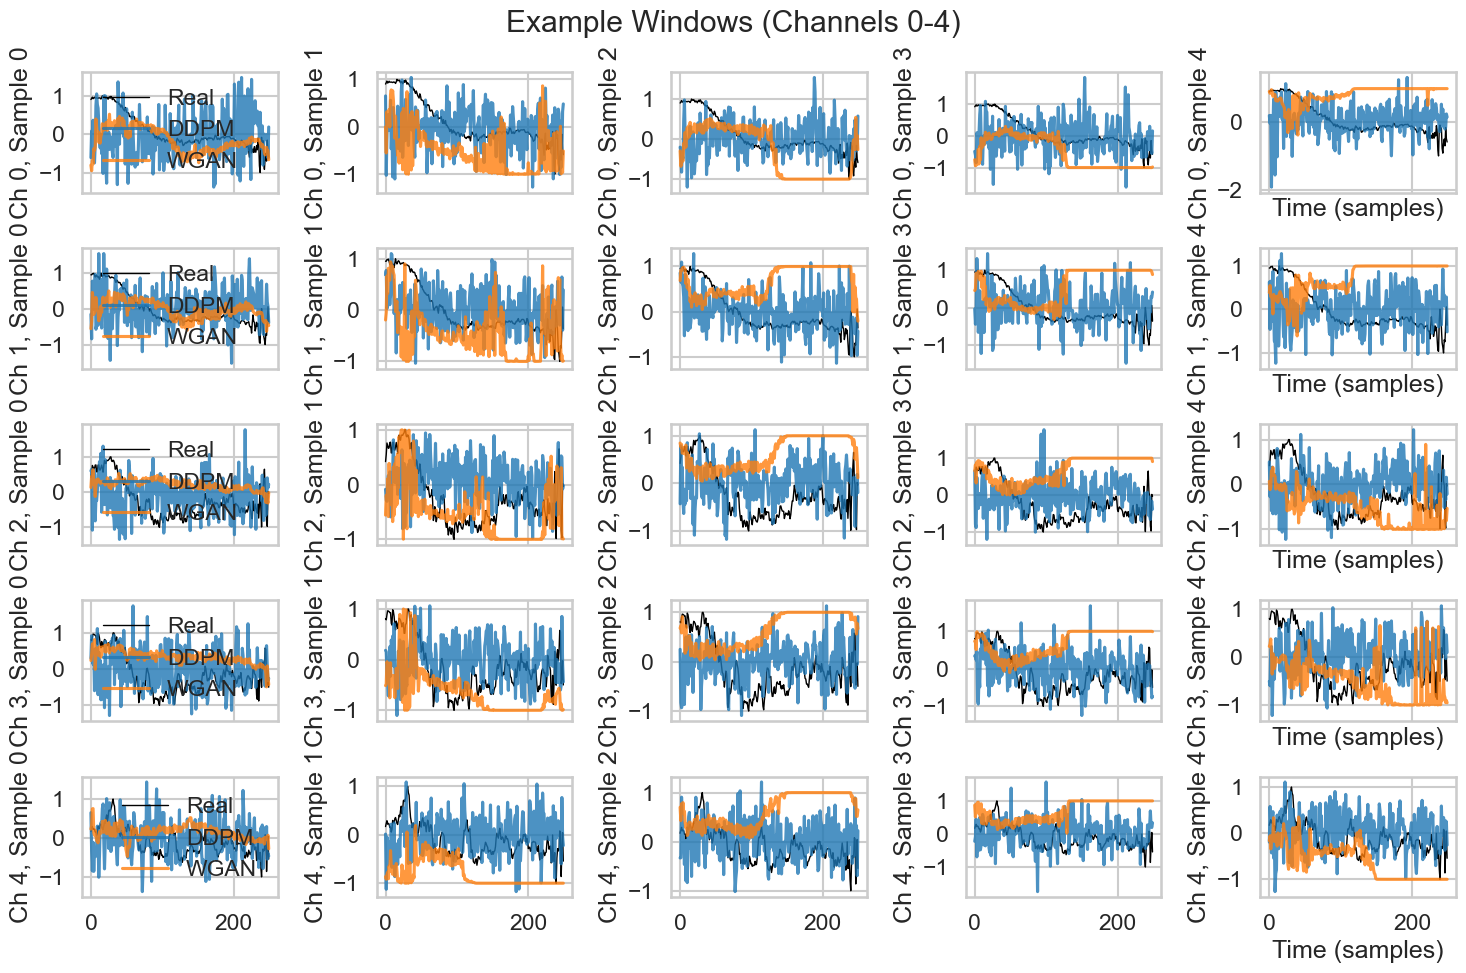

In [11]:
def plot_examples_multi(channels=[0,1,2,3,4], n=5, seed=0):
    random.seed(seed); np.random.seed(seed)
    fig, axes = plt.subplots(len(channels), n, figsize=(3*n, 2*len(channels)), sharex=True)
    if len(channels)==1: axes = [axes]
    for ci, channel in enumerate(channels):
        for i in range(n):
            axi = axes[ci][i] if len(channels)>1 else axes[i]
            if R.size: axi.plot(R[i%len(R), channel], label='Real', color='black', lw=1)
            if D.size: axi.plot(D[i%len(D), channel], label='DDPM', alpha=0.8)
            if G.size: axi.plot(G[i%len(G), channel], label='WGAN', alpha=0.8)
            if i==0: axi.legend(frameon=False)
            axi.set_ylabel(f'Ch {channel}, Sample {i}')
        axes[ci][-1].set_xlabel('Time (samples)')
    fig.suptitle('Example Windows (Channels 0-4)')
    plt.tight_layout()
    out = FIG_DIR / 'examples_windows_multi.png'
    fig.savefig(out, dpi=200)
    print('Saved', out)
    plt.show()
plot_examples_multi(channels=[0,1,2,3,4], n=5)

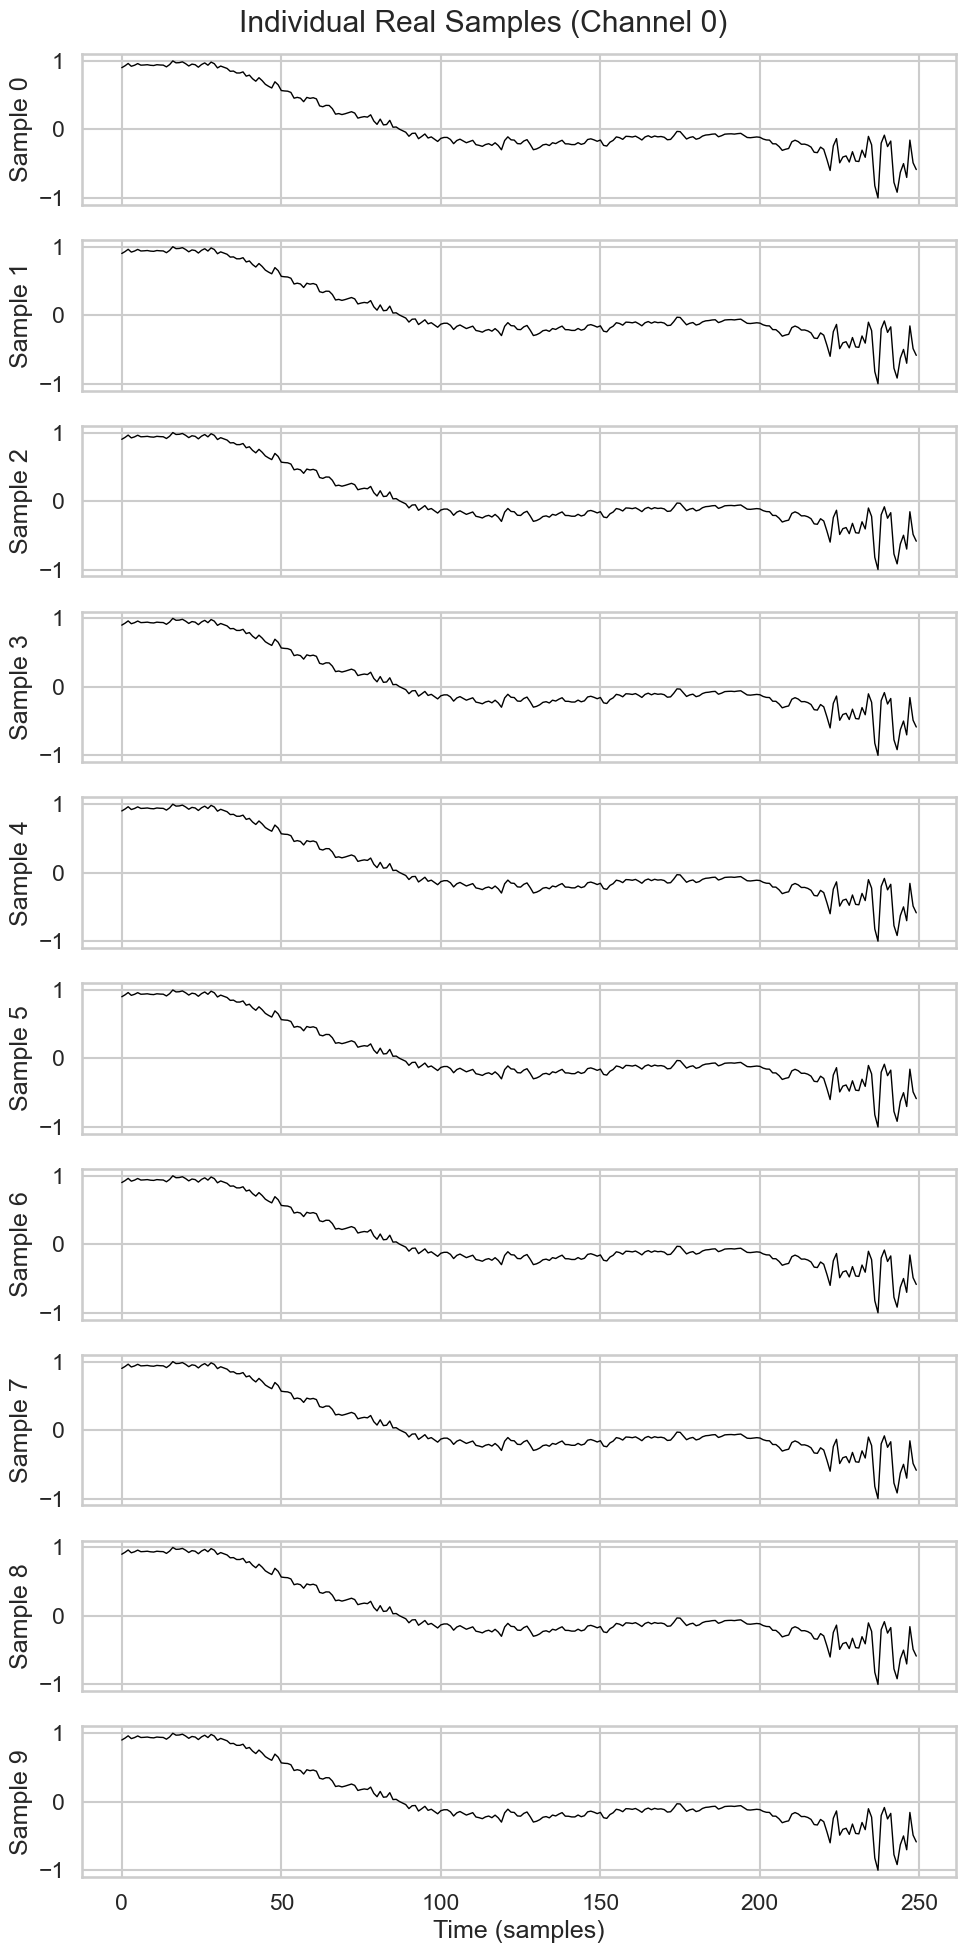

In [12]:
# Debug: Plot several individual real samples for a single channel to check for diversity and flatness
def plot_individual_real_samples(channel=0, n=10):
    if R.size == 0:
        print('No real samples loaded.')
        return
    fig, axes = plt.subplots(n, 1, figsize=(10, 2*n), sharex=True)
    if n == 1: axes = [axes]
    for i in range(n):
        axi = axes[i]
        axi.plot(R[i % len(R), channel], color='black', lw=1)
        axi.set_ylabel(f'Sample {i}')
    axes[-1].set_xlabel('Time (samples)')
    fig.suptitle(f'Individual Real Samples (Channel {channel})')
    plt.tight_layout()
    plt.show()
plot_individual_real_samples(channel=0, n=10)

## Visualization: Example Windows (Channels 0-4 Side by Side)
Compare real vs synthetic windows for channels 0-4 in a single figure.

Saved C:\works\ArtifactGen\paper\figs\examples_windows.png


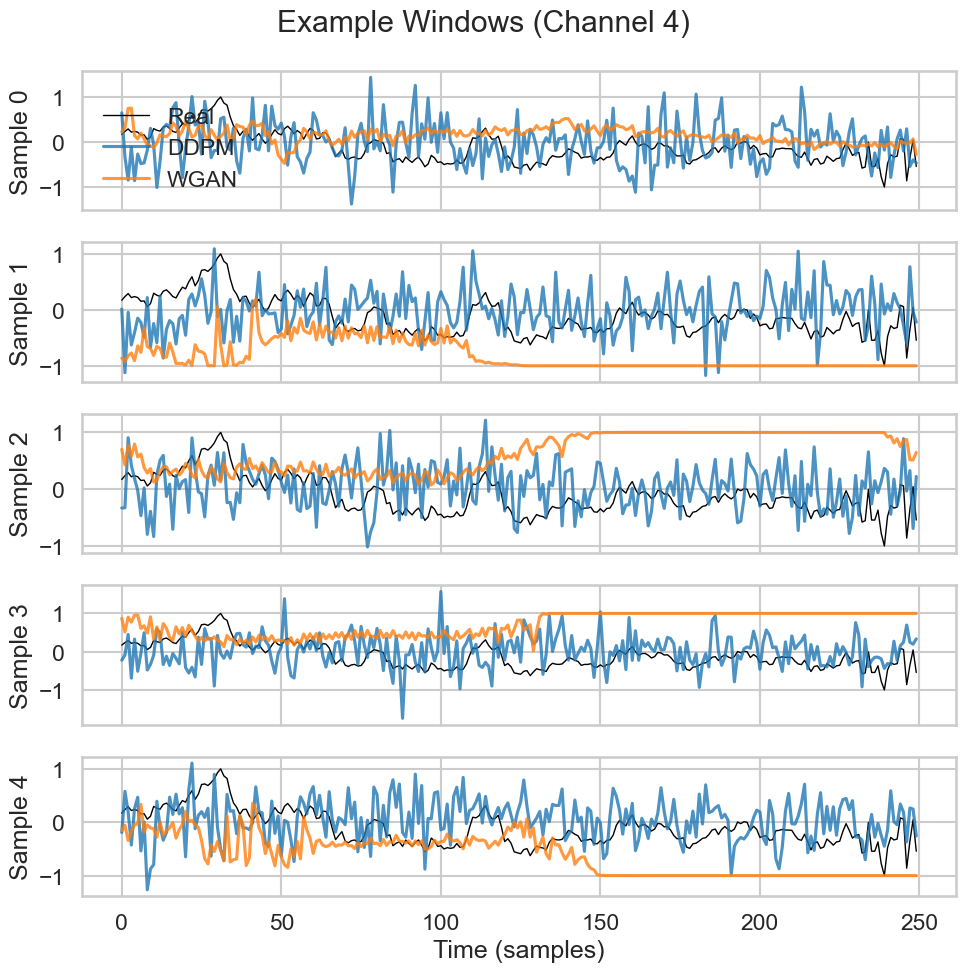

In [13]:
def plot_examples(cls=None, channel=0, n=5, seed=0):
    random.seed(seed); np.random.seed(seed)
    fig, ax = plt.subplots(n, 1, figsize=(10, 2*n), sharex=True)
    if n==1: ax=[ax]
    for i in range(n):
        axi = ax[i]
        if R.size: axi.plot(R[i%len(R), channel], label='Real', color='black', lw=1)
        if D.size: axi.plot(D[i%len(D), channel], label='DDPM', alpha=0.8)
        if G.size: axi.plot(G[i%len(G), channel], label='WGAN', alpha=0.8)
        if i==0: axi.legend(frameon=False)
        axi.set_ylabel(f'Sample {i}')
    ax[-1].set_xlabel('Time (samples)')
    fig.suptitle('Example Windows (Channel %d)' % channel)
    plt.tight_layout()
    out = FIG_DIR / 'examples_windows.png'
    fig.savefig(out, dpi=200)
    print('Saved', out)
    plt.show()
plot_examples(channel=4, n=5)

## Visualization: Example Windows (Channel 4)
Overlay real vs synthetic windows for channel 4.

Saved C:\works\ArtifactGen\paper\figs\examples_windows.png


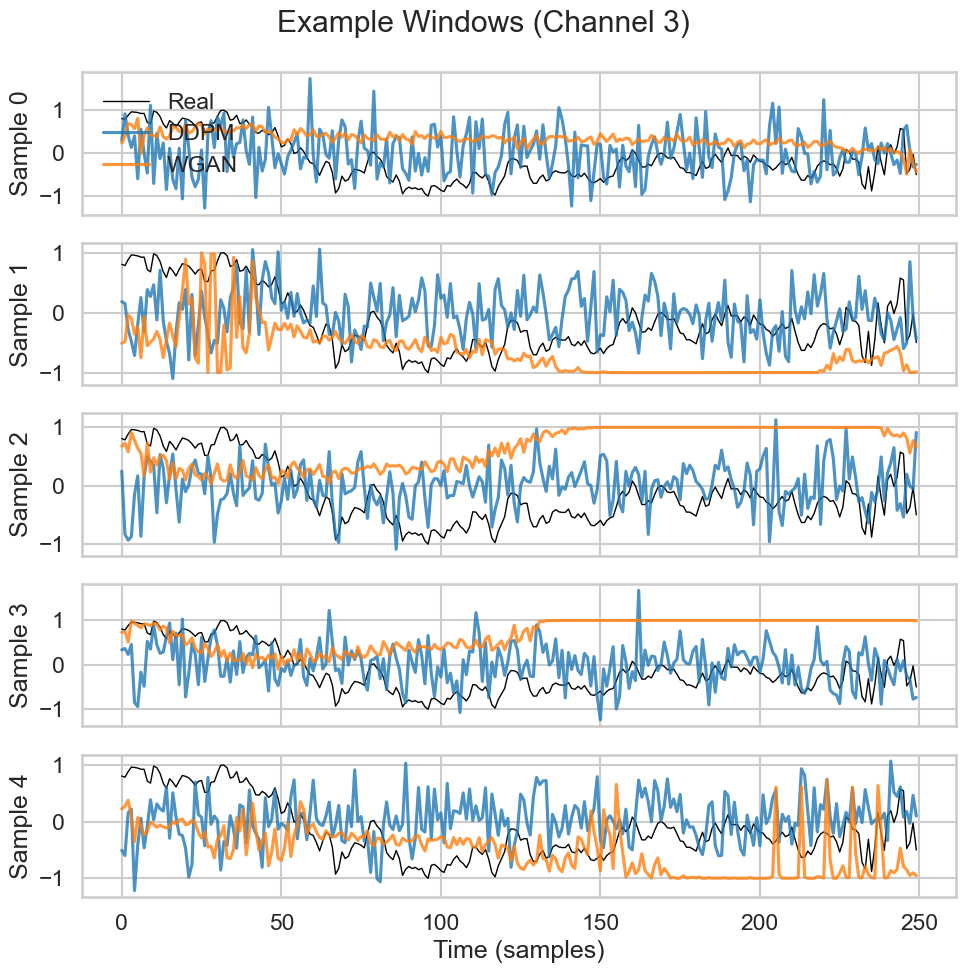

In [14]:
plot_examples(channel=3, n=5)

## Visualization: Example Windows (Channel 3)
Overlay real vs synthetic windows for channel 3.

Saved C:\works\ArtifactGen\paper\figs\examples_windows.png


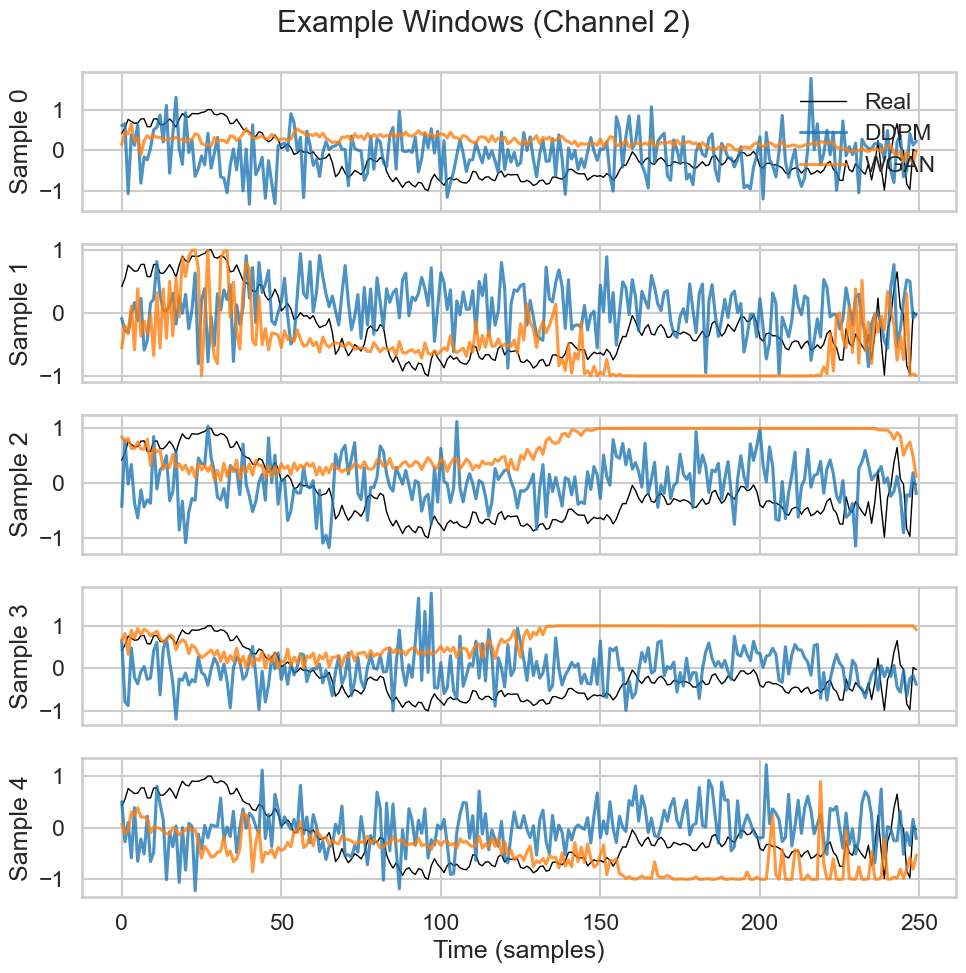

In [15]:
plot_examples(channel=2, n=5)

## Visualization: Example Windows (Channel 2)
Overlay real vs synthetic windows for channel 2.

Saved C:\works\ArtifactGen\paper\figs\examples_windows.png


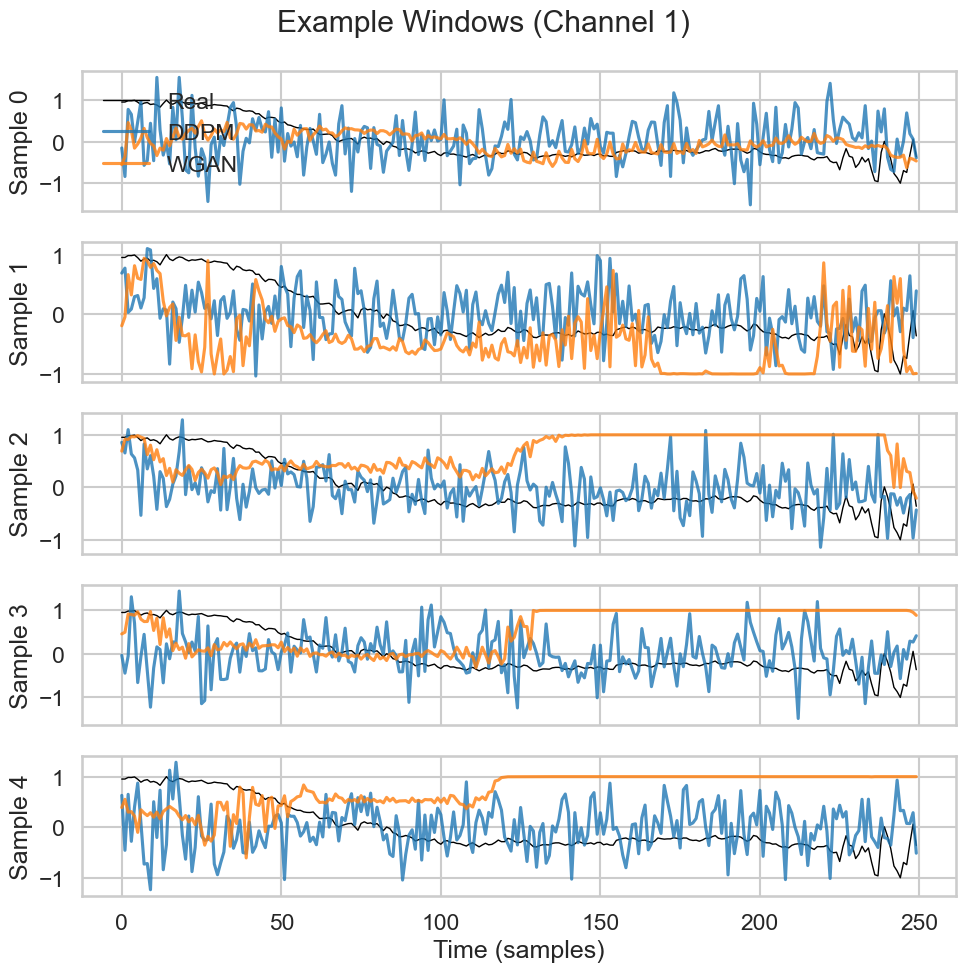

In [16]:
plot_examples(channel=1, n=5)

Saved C:\works\ArtifactGen\paper\figs\examples_windows.png


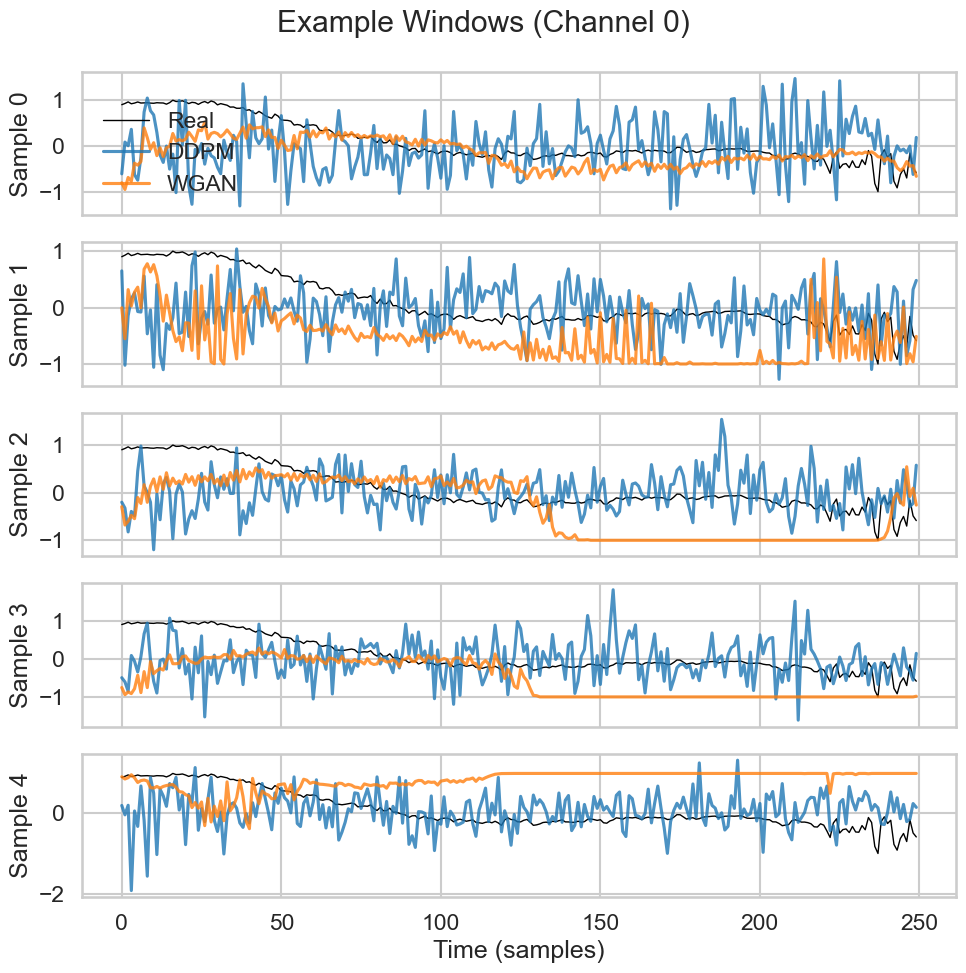

In [17]:
def plot_examples(cls=None, channel=0, n=5, seed=0):
    random.seed(seed); np.random.seed(seed)
    fig, ax = plt.subplots(n, 1, figsize=(10, 2*n), sharex=True)
    if n==1: ax=[ax]
    for i in range(n):
        axi = ax[i]
        if R.size: axi.plot(R[i%len(R), channel], label='Real', color='black', lw=1)
        if D.size: axi.plot(D[i%len(D), channel], label='DDPM', alpha=0.8)
        if G.size: axi.plot(G[i%len(G), channel], label='WGAN', alpha=0.8)
        if i==0: axi.legend(frameon=False)
        axi.set_ylabel(f'Sample {i}')
    ax[-1].set_xlabel('Time (samples)')
    fig.suptitle('Example Windows (Channel %d)' % channel)
    plt.tight_layout()
    out = FIG_DIR / 'examples_windows.png'
    fig.savefig(out, dpi=200)
    print('Saved', out)
    plt.show()
plot_examples(channel=0, n=5)

## Visualization: PSD Comparison
Average channel-aggregated PSD overlay with log-power scale.

Saved C:\works\ArtifactGen\paper\figs\psd_comparison.png


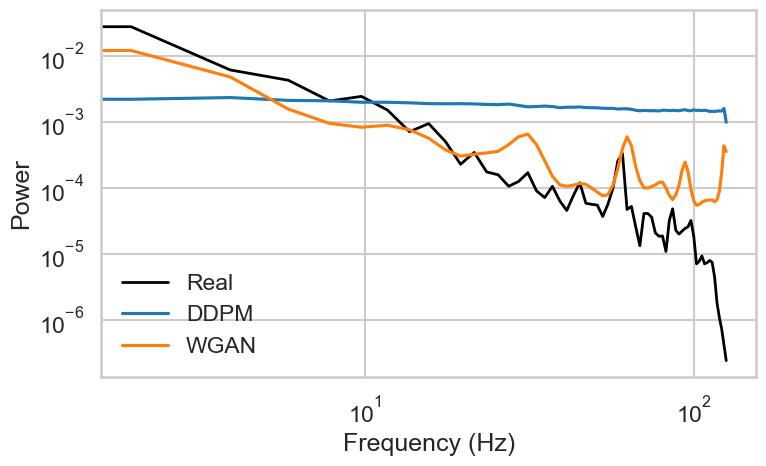

In [18]:
def plot_psd():
    if len(fR)==0: return
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    ax.plot(fR, psdR.mean(axis=0), label='Real', color='black', lw=2)
    if psdD_a.size: ax.plot(fR, psdD_a.mean(axis=0), label='DDPM')
    if psdG_a.size: ax.plot(fR, psdG_a.mean(axis=0), label='WGAN')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.legend(frameon=False)
    fig.tight_layout()
    out = FIG_DIR / 'psd_comparison.png'
    fig.savefig(out, dpi=200)
    print('Saved', out)
    plt.show()
plot_psd()

## Embedding Visualization (t-SNE / UMAP)
We project flattened windows. (For publication quality, replace with encoder feature embeddings.)

Saved C:\works\ArtifactGen\paper\figs\embedding_tsne.png


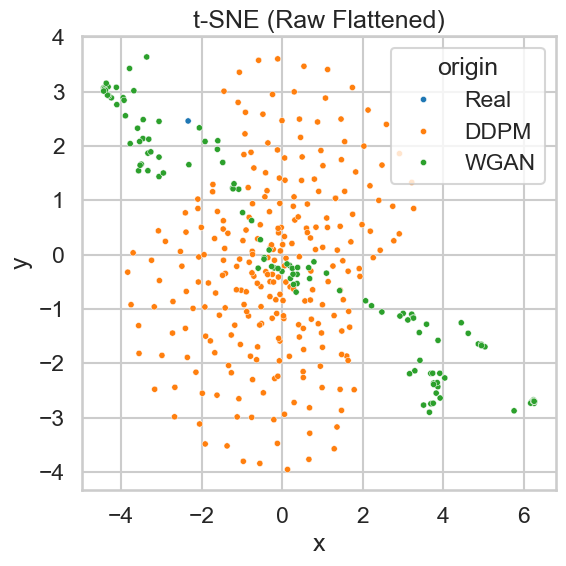

c:\works\ArtifactGen\venv\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Saved C:\works\ArtifactGen\paper\figs\embedding_umap.png


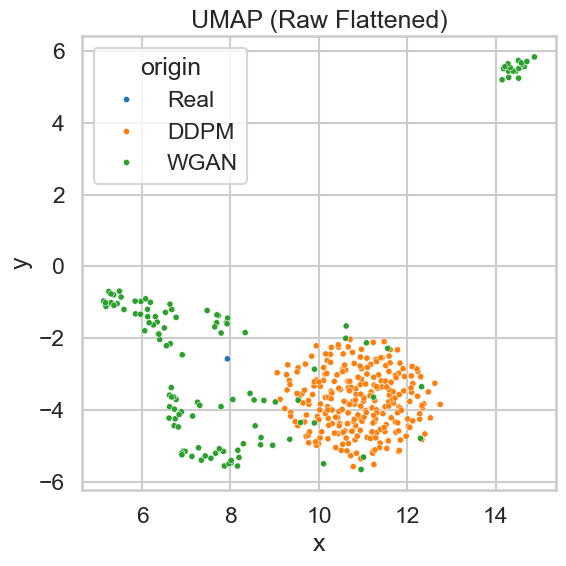

In [19]:
def build_embedding(R, D, G, max_per=300):
    data = []; labels=[]; origin=[]
    # Find minimum feature dimension across all non-empty blocks
    shapes = [block.shape for block in [R, D, G] if block.size > 0]
    if not shapes: return None, None
    min_feat = min([s[1]*s[2] if len(s) == 3 else s[-1] for s in shapes])
    def add(block, name):
        if block.size==0: return
        k = min(block.shape[0], max_per)
        idx = np.random.choice(block.shape[0], k, replace=False)
        flat = block[idx].reshape(k, -1)
        # Truncate to min_feat columns
        if flat.shape[1] > min_feat:
            flat = flat[:, :min_feat]
        elif flat.shape[1] < min_feat:
            # Pad with zeros if needed
            pad = np.zeros((k, min_feat-flat.shape[1]))
            flat = np.hstack([flat, pad])
        data.append(flat)
        labels.extend([name]*k)
    add(R,'Real'); add(D,'DDPM'); add(G,'WGAN')
    if not data: return None, None
    X = np.vstack(data)
    return X, labels
Xemb, lab_emb = build_embedding(R, D, G)
if Xemb is not None:
    tsne = TSNE(n_components=2, init='pca', random_state=42, perplexity=min(30, max(5, Xemb.shape[0]//10)))
    X2 = tsne.fit_transform(Xemb)
    fig, ax = plt.subplots(figsize=(6,6))
    df_emb = pd.DataFrame({'x':X2[:,0],'y':X2[:,1],'origin':lab_emb})
    sns.scatterplot(data=df_emb, x='x', y='y', hue='origin', s=20, ax=ax)
    ax.set_title('t-SNE (Raw Flattened)')
    fig.tight_layout()
    out = FIG_DIR / 'embedding_tsne.png'
    fig.savefig(out, dpi=200)
    print('Saved', out)
    plt.show()
    if HAVE_UMAP:
        reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.2)
        X3 = reducer.fit_transform(Xemb)
        fig2, ax2 = plt.subplots(figsize=(6,6))
        df_emb2 = pd.DataFrame({'x':X3[:,0],'y':X3[:,1],'origin':lab_emb})
        sns.scatterplot(data=df_emb2, x='x', y='y', hue='origin', s=20, ax=ax2)
        ax2.set_title('UMAP (Raw Flattened)')
        fig2.tight_layout()
        out2 = FIG_DIR / 'embedding_umap.png'
        fig2.savefig(out2, dpi=200)
        print('Saved', out2)
        plt.show()

## Coverage Comparison
Class count distribution (raw counts).

In [20]:
cov_df = pd.DataFrame({'class':sorted(set(list(cov_real.keys())+list(cov_ddpm.keys())+list(cov_wgan.keys())))} )
cov_df['real'] = cov_df['class'].map(cov_real).fillna(0).astype(int)
cov_df['ddpm'] = cov_df['class'].map(cov_ddpm).fillna(0).astype(int)
cov_df['wgan'] = cov_df['class'].map(cov_wgan).fillna(0).astype(int)
cov_df

,class,real,ddpm,wgan
0,0,0,256,21
1,1,0,0,35
2,2,0,0,29
3,3,0,0,23
4,4,1,0,20


### Coverage Plot

Saved C:\works\ArtifactGen\paper\figs\coverage_bar.png


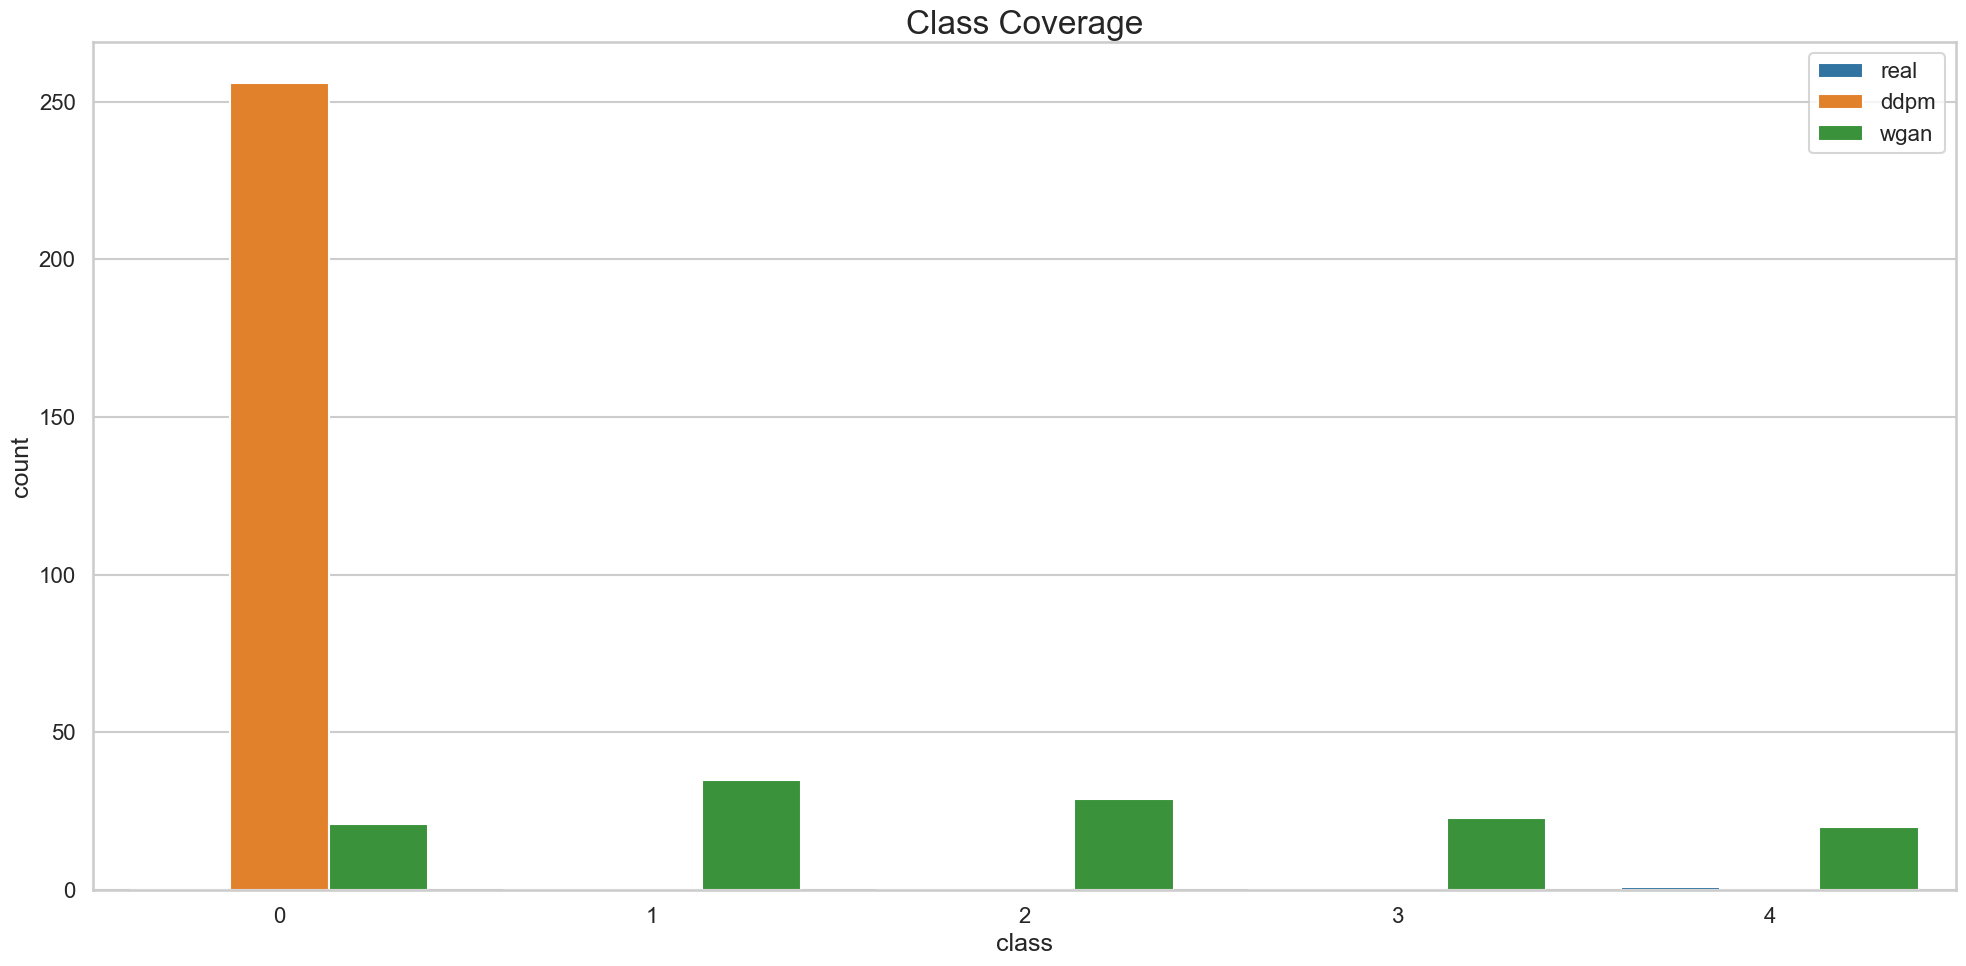

In [21]:
if not cov_df.empty:
    fig, ax = plt.subplots(figsize=(20,10))  # Much larger plot for maximum visibility
    covm = cov_df.melt(id_vars='class', value_vars=['real','ddpm','wgan'], var_name='source', value_name='count')
    sns.barplot(data=covm, x='class', y='count', hue='source', ax=ax)
    ax.set_title('Class Coverage', fontsize=24)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend(fontsize=16)
    fig.tight_layout()
    out = FIG_DIR / 'coverage_bar.png'
    fig.savefig(out, dpi=200)
    print('Saved', out)
    plt.show()

## Publication Tables (LaTeX Export Helpers)

In [22]:
def to_latex(df, fname):
    out = FIG_DIR / fname
    with open(out, 'w', encoding='utf-8') as f: f.write(df.to_latex(index=False, float_format=lambda x: f'{x:.3g}'))
    print('Wrote', out)
to_latex(metrics_table, 'table_metrics.tex')
to_latex(band_table, 'table_bandpower.tex')
to_latex(channel_table.head(12), 'table_channel_effects.tex')
to_latex(cov_df, 'table_coverage.tex')

Wrote C:\works\ArtifactGen\paper\figs\table_metrics.tex
Wrote C:\works\ArtifactGen\paper\figs\table_bandpower.tex
Wrote C:\works\ArtifactGen\paper\figs\table_channel_effects.tex
Wrote C:\works\ArtifactGen\paper\figs\table_coverage.tex


## Next Steps / Extensions
- Integrate encoder-based feature extraction (CNN or self-supervised) to compute FID/KID & Precision/Recall.\n
- Add functional metrics: Train classifier on real -> test synthetic (TRTS) & train synthetic -> test real (TSTR).\n
- Add conditional guidance strength sweeps for DDPM to analyze class fidelity vs diversity.\n
- Statistical tests (e.g., Wilcoxon) on per-channel or band distributions.\n
- Panel assembly script to combine exported PNGs into multi-part figure.

## Summary
This table shows per-class metrics. Lower MMD and PSD error indicate better performance for that class.

## Per-Class Results Table

Below is the summary table showing per-class metrics for DDPM and WGAN-GP models. Lower MMD and PSD error indicate better performance for that class. Use this table to compare how well each model captures the distribution of real EEG artifact windows across different classes.